# Logistic regression with PyMC3

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import numpy.random as rnd
import seaborn as sns
from matplotlib import animation
import matplotlib.pyplot as plt
import pymc3 as pm
import pickle
import theano

In [3]:
[m for m in dir(pm.step_methods) if m[0].isupper()]

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CSG',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'SGFS',
 'SMC',
 'Slice']

## Linear Regression Demo

In [10]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
true_regression_line = true_intercept + true_slope * x
y = true_regression_line + np.random.normal(scale=.5, size=size)

x_shared = theano.shared(x)

In [28]:
with pm.Model() as linear_regression: # model specification

    # Define priors
    sd = pm.HalfCauchy('sigma', beta=10, testval=1) # unique name for each variable
    intercept = pm.Normal('intercept', 0, sd=20)
    slope = pm.Normal('slope', 0, sd=20)

    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + slope * x_shared, sd=sd, observed=y)

    # Inference
    trace = pm.sample(draws=2500, # draw 2500 samples from posterior using NUTS sampling
                      tune=1000, 
                      cores=4) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:12<00:00, 1161.37draws/s]


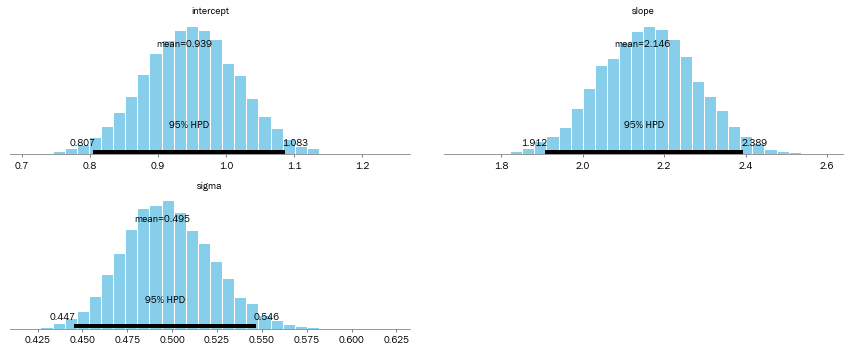

In [29]:
pm.plot_posterior(trace);

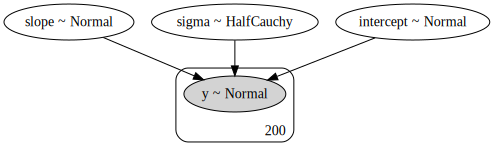

In [47]:
pm.model_to_graphviz(linear_regression)

## Logistic Regression: Refresher

### The Data

Let's read the dataset. This is a post-processed version of the [UCI Adult dataset](http://archive.ics.uci.edu/ml/datasets/Adult).

In [3]:
data = pd.read_csv("adult_us_postprocessed.csv")
data.head()

,sex,age,educ,hours,income_more_50K
0,Male,39,13,40,0
1,Male,50,13,13,0
2,Male,38,9,40,0
3,Male,53,7,40,0
4,Female,28,13,40,0


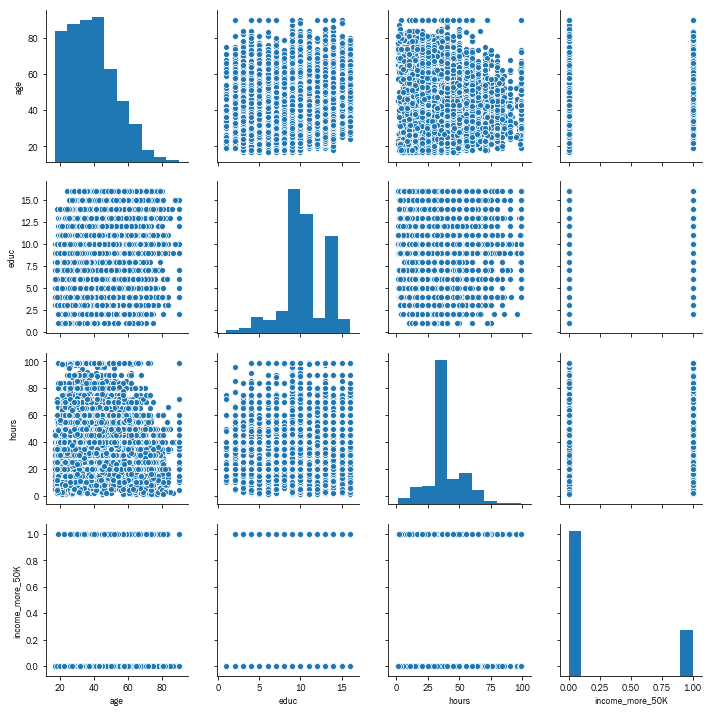

In [30]:
sns.pairplot(data);

### MAP inference

#### Probability Model Specification

In [4]:
def print_map(result):
    return pd.Series({k: np.asscalar(v) for k, v in result.items()})

In [5]:
with pm.Model() as manual_logistic_model:
    # random variables for coefficients with
    # uninformative priors for each parameter
    
    intercept = pm.Normal('intercept', 0, sd=100)
    beta_1 = pm.Normal('beta_1', 0, sd=100)
    beta_2 = pm.Normal('beta_2', 0, sd=100)

    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.    
    likelihood = pm.invlogit(intercept + beta_1 * data.hours + beta_2 * data.educ)    
    
    # Bernoulli random vector with probability of success 
    # given by sigmoid function and actual data as observed 
    pm.Bernoulli(name='logit', p=likelihood, observed=data.income_more_50K)
    
    # compute maximum a-posteriori estimate 
    # for logistic regression weights
    manual_map_estimate = pm.find_MAP()

logp = -16,190, ||grad|| = 1.1486e+05: 100%|██████████| 31/31 [00:00<00:00, 172.37it/s]  


In [6]:
print_map(manual_map_estimate)

intercept   -6.538065
beta_1       0.040720
beta_2       0.346118
dtype: float64

In [7]:
with pm.Model() as logistic_model:
    # train logistic model using pm.glm.GLM.from_formula.    
    pm.glm.GLM.from_formula('income_more_50K ~ hours + educ', 
                            data, 
                            family=pm.glm.families.Binomial()) 
    map_estimate = pm.find_MAP()

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
logp = -15,374, ||grad|| = 215.33: 100%|██████████| 25/25 [00:00<00:00, 73.20it/s]     


In [8]:
print_map(map_estimate)

Intercept   -6.538067
hours        0.040720
educ         0.346118
dtype: float64

### Markov Chain Monte Carlo

To find credible regions let's perform MCMC inference.

In [9]:
def plot_traces(traces, burnin=2000):
    ''' 
    Plot traces with overlaid means and values
    '''
    summary = pm.summary(traces[burnin:])
    lines = {k: v['mean']
             for k, v in summary.iterrows()}
    ax = pm.traceplot(traces[burnin:],
                      figsize=(15, len(traces.varnames)*1.5),
                      lines=lines)

    for i, mn in enumerate(summary['mean']):
        ax[i, 0].annotate(f'{mn:.2f}', 
                          xy=(mn, 0), 
                          xycoords='data', 
                          xytext=(5, 10), 
                          textcoords='offset points', 
                          rotation=90, 
                          va='bottom', 
                          fontsize='large', 
                          color='#AA0022')

#### Metropolis-Hastings
We will use the Metropolis-Hastings algorithm to sample from the posterior distribution.

Explore the hyperparameters of Metropolis-Hastings such as the proposal distribution variance to speed up the convergence. 
Use `plot_traces` function to visually inspect the convergence.

You may also use MAP-estimate to initialize the sampling scheme to speed things up. This will make the warmup (burnin) period shorter since you will start from a probable point.

In [11]:
with pm.Model() as logistic_model:
    # Train Bayesian logistic regression model
    pm.glm.GLM.from_formula('income_more_50K ~ sex + age+ I(age ** 2) + hours + educ',
                            data,
                            family=pm.glm.families.Binomial())

    trace = pm.sample(tune=1000,
                      draws=25000,
                      step=pm.Metropolis(),
                      cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [educ]
>Metropolis: [hours]
>Metropolis: [I(age ** 2)]
>Metropolis: [age]
>Metropolis: [sex[T. Male]]
>Metropolis: [Intercept]
Sampling 4 chains: 100%|██████████| 104000/104000 [1:09:47<00:00, 24.84draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


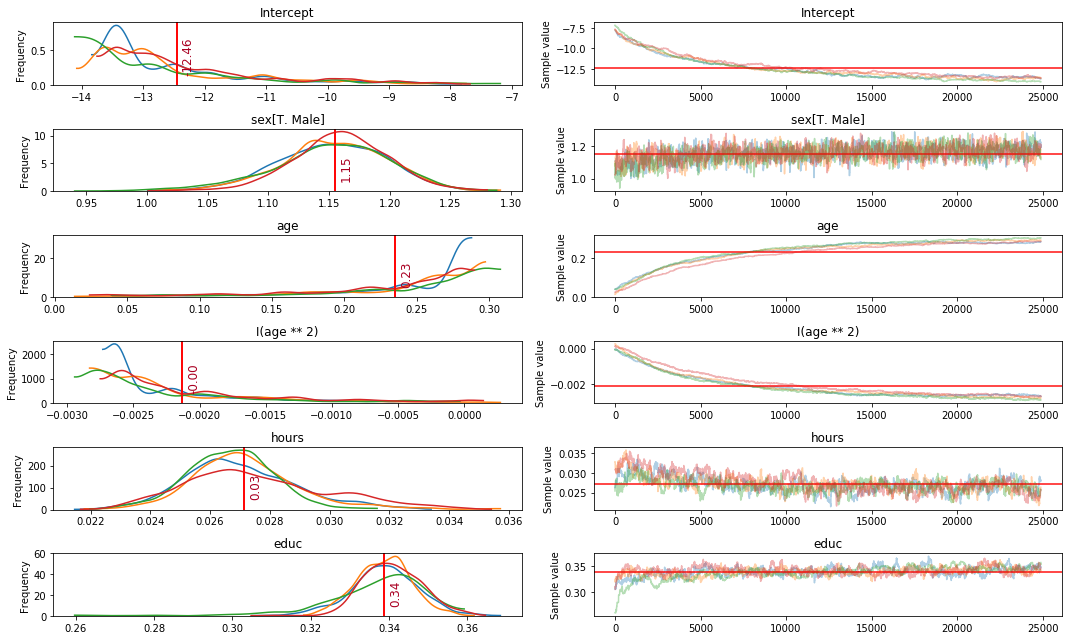

In [16]:
plot_traces(trace, burnin=100)

In [12]:
with open('models/logistic_hastings_auto_init_new.pkl', 'wb') as buff:
    pickle.dump({'model': logistic_model, 'trace': trace}, buff)

In [13]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-12.436425,1.422989,0.141500,-14.070973,-9.230229,13.153681,1.006793
sex[T. Male],1.154232,0.044576,0.002568,1.062906,1.237800,58.136065,1.003475
age,0.233947,0.065340,0.006513,0.083470,0.306926,12.877268,1.011121
I(age ** 2),-0.002120,0.000708,0.000071,-0.002910,-0.000480,12.835902,1.011580
hours,0.027134,0.001979,0.000158,0.023521,0.031463,24.880984,1.021023
educ,0.338614,0.009928,0.000801,0.320514,0.355773,28.403672,1.016094


#### NUTS sampler
Use pm.sample without specifying a particular sampling method (pymc3 will choose it automatically).
The sampling algorithm that will be used in this case is NUTS, which is a form of Hamiltonian Monte Carlo, in which parameters are tuned automatically. This is an advanced method that we hadn't cover in the lectures, but it usually converges faster and gives less correlated samples compared to vanilla Metropolis-Hastings.

Since the NUTS sampler doesn't require to tune hyperparameters, let's run it for 10 times more iterations than Metropolis-Hastings.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 5 columns):
sex                32561 non-null object
age                32561 non-null int64
educ               32561 non-null int64
hours              32561 non-null int64
income_more_50K    32561 non-null int64
dtypes: int64(4), object(1)
memory usage: 1.2+ MB


In [26]:
logistic_model2.test_point

{'Intercept': array(0.),
 'sex[T. Male]': array(0.),
 'age': array(0.),
 'I(age ** 2)': array(0.),
 'hours': array(0.),
 'educ': array(0.)}

In [32]:
with pm.Model() as logistic_model2:
    formula = 'income_more_50K ~ sex + age+ I(age ** 2) + hours + educ'
    pm.glm.GLM.from_formula(formula=formula,
                            data=data,
                            family=pm.glm.families.Binomial())
    trace_logistic_model = pm.sample(draws=2000, init='adapt_diag', cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [educ, hours, I(age ** 2), age, sex[T. Male], Intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [48:36<00:00,  1.04draws/s] 
The acceptance probability does not match the target. It is 0.9568230376056446, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9495572205383989, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9558743986358418, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9844383486234759, but should be close to 0.8. Try to increase the number of tuning steps.


In [36]:
pm.summary(trace_logistic_model)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-13.778973,0.211036,0.004021,-14.199171,-13.382955,2906.463365,0.999943
sex[T. Male],1.176852,0.037460,0.000467,1.103649,1.249359,5210.588308,0.999768
age,0.295601,0.008629,0.000176,0.278687,0.312206,2709.096764,0.999811
I(age ** 2),-0.002789,0.000095,0.000002,-0.002970,-0.002598,2757.548635,0.999802
hours,0.026111,0.001347,0.000016,0.023508,0.028759,6056.224182,0.999948
educ,0.342791,0.006740,0.000085,0.329447,0.355797,5733.351785,0.999980


/Users/Stefan/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/Stefan/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/Stefan/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/Stefan/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.6/site-packages/matplotlib/axes/

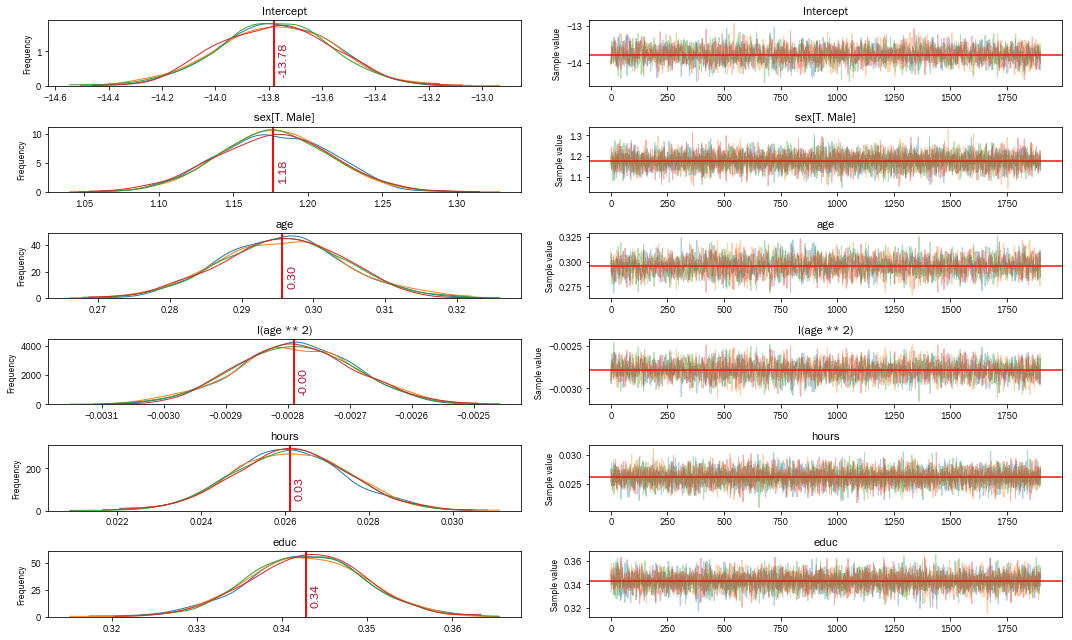

In [38]:
plot_traces(trace_logistic_model, burnin=100)

In [47]:
import statsmodels.formula.api as smf
model = smf.logit(formula = 'income ~ age+ I(age ** 2) + hours + educ', data=data)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.433961
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 income   No. Observations:                29170
Model:                          Logit   Df Residuals:                    29165
Method:                           MLE   Df Model:                            4
Date:                Tue, 18 Dec 2018   Pseudo R-squ.:                  0.2219
Time:                        16:50:32   Log-Likelihood:                -12659.
converged:                       True   LL-Null:                       -16268.
                                        LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -13.2074      0.215    -61.504      0.000     -13.628     -12.787
age             0.2971    

#### Estimating the odds ratio
Now, let's build the posterior distribution on the odds ratio given the dataset (approximated by MCMC).

/Users/Stefan/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


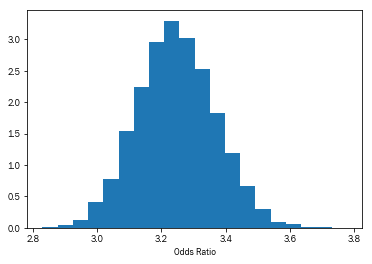

In [42]:
# We don't need to use a large burn-in here, since we initialize sampling
# from a good point (from our approximation of the most probable
# point (MAP) to be more precise).
burnin = 100
b = trace_logistic_model['sex[T. Male]'][burnin:]
plt.hist(np.exp(b), bins=20, normed=True)
plt.xlabel("Odds Ratio")
plt.show()


Finally, we can find a credible interval  (recall that credible intervals are Bayesian and confidence intervals are frequentist) for this quantity. This may be the best part about Bayesian statistics: we get to interpret credibility intervals the way we've always wanted to interpret them. We are 95% confident that the odds ratio lies within our interval!

In [43]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
print("P(%.3f < Odds Ratio < %.3f) = 0.95" % (np.exp(lb), np.exp(ub)))

P(3.013 < Odds Ratio < 3.487) = 0.95


### Interpreting the results

In [4]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
                 header=None, 
                 names=['age', 'workclass', 'fnlwgt',
                'education-categorical', 'educ',
                'marital-status', 'occupation',
                'relationship', 'race', 'sex',
                'captial-gain', 'capital-loss',
                'hours', 'native-country',
                'income'])
data = data.loc[~pd.isnull(data['income']) & (data['native-country']==" United-States"), 
                ['income', 'age', 'educ', 'hours']]
data.income = (data.income.str.strip() == '>50K').astype(int)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29170 entries, 0 to 32560
Data columns (total 4 columns):
income    29170 non-null int64
age       29170 non-null int64
educ      29170 non-null int64
hours     29170 non-null int64
dtypes: int64(4)
memory usage: 1.1 MB


In [6]:
with pm.Model() as logistic_model:
    formula = 'income ~ age + I(age ** 2) + hours + educ'
    pm.glm.GLM.from_formula(formula=formula, data=data,
                            family=pm.glm.families.Binomial())
    trace_logistic_model = pm.sample(draws=2000, tune=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (1 chains in 1 job)
NUTS: [educ, hours, I(age ** 2), age, Intercept]
  0%|          | 0/3000 [00:00<?, ?it/s]


ValueError: Bad initial energy: inf. The model might be misspecified.

## Setting things up
You don't need to modify the code below, it sets up the plotting functions. The code is based on [MCMC visualization tutorial](https://twiecki.github.io/blog/2014/01/02/visualizing-mcmc/).

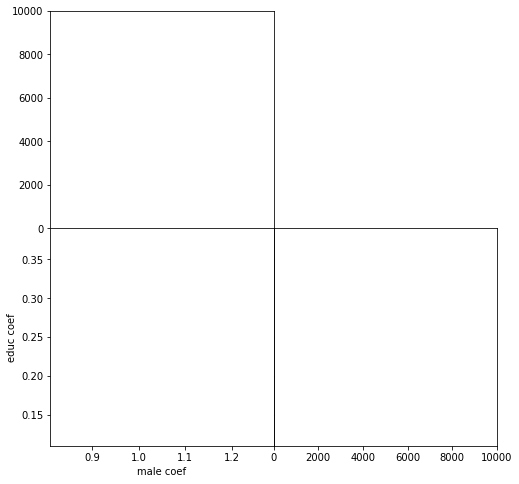

In [26]:
from IPython.display import HTML
# Number of MCMC iteration to animate.
burnin = 1000
samples = 10000

fig = plt.figure(figsize=(8, 8))
s_width = (0.81, 1.29)
a_width = (0.11, 0.39)
samples_width = (0, samples)
ax1 = fig.add_subplot(221, xlim=s_width, ylim=samples_width)
ax2 = fig.add_subplot(224, xlim=samples_width, ylim=a_width)
ax3 = fig.add_subplot(223, xlim=s_width, ylim=a_width,
                      xlabel='male coef',
                      ylabel='educ coef')
fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
lines = [line1, line2, line3, line4, line5, line6]

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    with animated_logistic_model:
        if i == 0:
            for j in range(burnin): iter_sample.__next__() 
        trace = iter_sample.__next__()
    if i % 250 == 0:
        print(pm.trace_to_dataframe(trace).iloc[-1])
    line1.set_data(trace['sex[T. Male]'][::-1], range(len(trace['sex[T. Male]'])))
    line2.set_data(range(len(trace['educ'])), trace['educ'][::-1])
    line3.set_data(trace['sex[T. Male]'], trace['educ'])
    line4.set_data(trace['sex[T. Male]'], trace['educ'])
    male = trace['sex[T. Male]'][-1]
    educ = trace['educ'][-1]
    line5.set_data([male, male], [educ, a_width[1]])
    line6.set_data([male, s_width[1]], [educ, educ])
    return lines

## Animating Metropolis-Hastings

In [19]:
with pm.Model() as animated_logistic_model:
    formula = 'income_more_50K ~ sex + age+ I(age ** 2) + hours + educ'
    pm.glm.GLM.from_formula(formula=formula,
                            data=data,
                            family=pm.glm.families.Binomial())
    step = pm.Metropolis()
    map_estimate = pm.find_MAP()
    iter_sample = pm.iter_sample(draws=burnin + samples,
                                 step=step,
                                 random_seed=42)
anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=init,
                               frames=samples,
                               interval=5,
                               blit=True)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim.save('figures/metropolis_hastings.mp4', writer=writer)

# HTML(anim.to_html5_video())

logp = -22,609, ||grad|| = 1.1051e+07: 100%|██████████| 8/8 [00:00<00:00, 234.86it/s]


saving


## Animating NUTS
Now rerun the animation providing the NUTS sampling method as the step argument.

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 5 columns):
sex                32561 non-null object
age                32561 non-null int64
educ               32561 non-null int64
hours              32561 non-null int64
income_more_50K    32561 non-null int64
dtypes: int64(4), object(1)
memory usage: 1.2+ MB


In [28]:
with pm.Model() as animated_logistic_model:
    formula = 'income_more_50K ~ sex + age+ I(age ** 2) + hours + educ'
    pm.glm.GLM.from_formula(formula=formula,
                            data=data,
                            family=pm.glm.families.Binomial())
#     start, _ = pm.sampling.init_nuts(random_seed=42, init='adapt_diag', chains=1)
    iter_sample = pm.iter_sample(draws=burnin + samples,
                                 step=pm.NUTS(),
                                 start=pm.find_MAP(),
                                 random_seed=42)
anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=init,
                               frames=samples,
                               interval=5,
                               blit=True)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim.save('figures/nuts.mp4', writer=writer)

# HTML(anim.to_html5_video())

logp = -22,609, ||grad|| = 1.1051e+07: 100%|██████████| 8/8 [00:00<00:00, 221.92it/s]


ValueError: Bad initial energy: inf. The model might be misspecified.